In [61]:
# Import universal packages:
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from cdo import Cdo
cdo = Cdo()
import cellpylib as cpl
import time
from matplotlib import animation
from scipy.signal import convolve2d
import cv2 as cv
from numba import njit
import time


# The model

In [96]:

def update(last_x, last_Tns, last_counter, step, N_steps_day, DIU):

    """Makes one step in the cellular automaton.
    Args:
        last_x (np.array): current state of the rain field (1: rain, 0: no rain)
        last_Tns (np.array): current probability matrix (physically near surface temperature T_ns, in units: 20 K)
        last_counter (np.array): keeping track of lifetimes of rain events 
        step : what step of the cellular automaton are we updating
        N_steps_day : how many steps in a day
        DIU : True, if oscillating Ts, False, if constant Ts
    Returns:
        x (np.array): updated state of the rain field
        Tns (np.array): updated state of the near surface temperature
    """
    
    parameters(N_steps_day) #calling all parameters
    
    if DIU == True:
        cp_cooling = cp_cooling_DIU
    elif DIU == False:
        cp_cooling = cp_cooling_OCEAN
    
    new_counter = last_counter
    new_counter = np.where(np.logical_and(last_x==1,last_counter==lifetime_rain),-1,new_counter)
    deactivate_CP_regions = np.where(new_counter<0,-cp_cooling,0)
    
    new_counter = np.where(np.logical_and(last_x==1,last_counter>=0,last_counter<lifetime_rain),new_counter+1,new_counter)
    
    
    
    
    new_Tns = last_Tns + D_T*(Ts(step, N_steps_day,DIU)-last_Tns) + deactivate_CP_regions

    
    kernel_diff = alpha * np.array([[0, 1, 0], 
                                    [1, 0, 1],
                                    [0, 1, 0]]) + (1-4*alpha)* np.array([[0, 0, 0], 
                                                                         [0, 1, 0],
                                                                         [0, 0, 0]])
    # diffusive process to smoothen out the field
    diffuse_Tns = convolve2d(new_Tns, kernel_diff, 'same', boundary = 'wrap')
    new_Tns = diffuse_Tns
    
    kernel = (1/8) * np.array([[1, 1, 1],
                               [1, 0, 1],
                               [1, 1, 1]])
    eightneighboravg = convolve2d(last_x, kernel, 'same', boundary = 'wrap')
    
    boost_Tns_inactive_regions = np.where(last_x==0,eightneighboravg,0)
    
    
    prolong_active_regions = np.where(np.logical_and(new_counter>0, new_counter<lifetime_rain),1,0)
    
    '''
  
    ## adding thermodynamic boost around CPs:
    cps = np.where(new_Tns < 0, 255, 0).astype(np.uint8)
    (nlabels, labels, stats, centroids) = cv.connectedComponentsWithStats(cps, connectivity=4)
    cp_areas = np.zeros(np.shape(cps))
    for label in range(1,nlabels):
        cp_areas = np.where(labels == label, stats[label,cv.CC_STAT_AREA], cp_areas).astype(np.uint8)
    new_counter = np.where(cp_areas > 1, new_counter - cp_areas , new_counter)
    ## cp_area < np.sqrt(np.size(cps))
    #np.logical_and(cp_areas > 1, last_counter==lifetime_rain)
    '''
    

    return new_Tns, prolong_active_regions, boost_Tns_inactive_regions, new_counter


def Ts(step, N_steps_day, DIU):
    parameters(N_steps_day)
    if (DIU==True):
        Ts = avg_Ts - amp_Ts*np.cos(2*np.pi*np.mod(step,N_steps_day)/N_steps_day)
    else:
        Ts = avg_Ts
    return Ts


def modellino(N_steps_day, tot_steps, DIU, persistence, branching, Tns_branch):
    parameters(N_steps_day)
    """ Game of Cloud, initiated from the night
    Args:
        pixels (int): number of cells in the row
        N_steps_day (int): number of timesteps in a day
        tot_steps (int): total number of steps to evolve the automaton
        lifetime_rain (int): number of steps that an active pixel persists
    Returns:    
        x: states of the automaton
        P: probability field of the automaton
    """
    

    
    x = np.zeros((tot_steps, pixels,pixels))
    Tns = np.zeros((tot_steps, pixels,pixels))
    Tns[0,:,:] = np.ones((pixels,pixels)) * avg_Ts
    
    if branching==True:
        Tns[0,:,:] = Tns_branch
        
    
    
    counter = np.zeros((tot_steps, pixels,pixels))
    trop_temp_saved=np.zeros(tot_steps)
    trop_temp_saved[0] = avg_Ts

    if DIU == True:
        cp_cooling = cp_cooling_DIU
    elif DIU == False:
        cp_cooling = cp_cooling_OCEAN
    
    
    t00 = time.time()
    # with global constraint:
    for step in range(0,tot_steps-1):
        (Tns[step + 1, :], prolong_active_regions, boost_Tns_inactive_regions, counter[step+1,:]) = update(
            x[step, :], Tns[step, :], counter[step,:], step, N_steps_day, DIU) 
        t0=time.time()
        trop_temp = trop_temp_saved[step]
        
        Tns[step + 1, :] = Tns[step + 1, :] + boost_Tns_inactive_regions * np.mean(Tns[step + 1, :]) * cp_cooling * interaction
        t1=time.time()
        # persistence
        if persistence=='yes':
            anomalies=Tns[step + 1,:]-np.mean(Tns[step + 1,:])
            boosted_Tns=Tns[step + 1,:]+anomalies*persistence_boost
            Tns[step + 1, :]=boosted_Tns
        t2=time.time()    
        Tns_unstable = np.where(np.logical_and((Tns[step + 1, :] - trop_temp)>0, prolong_active_regions==0), Tns[step + 1, :], 0)
        t3=time.time()

        x_pot = np.zeros((pixels,pixels))
        x_fire = np.zeros((pixels,pixels))
        x_pot = x_pot.flatten()

        sumTns = np.zeros(len(x_pot))
        t4=time.time()
        if np.sum(Tns_unstable)>0:
            sumTns = np.cumsum(Tns_unstable/np.sum(Tns_unstable))

        # loop to select among positively buoyant pixels:
        # let a pixel fire, update free_trop_temp, continue until there are no more pixels

            for fire in range(len(sumTns)):
                random_number = np.random.rand()
                selection_index = np.where(sumTns>=random_number)[0][0] 
                if (trop_temp < Tns_unstable.flatten()[selection_index] and x_pot[selection_index] == 0):
                    x_pot[selection_index] = 1
                    trop_temp = trop_temp + event_heating 
        t5=time.time()
        x_fire = x_pot.reshape((pixels,pixels))

        trop_temp = trop_temp - trop_cooling 

        trop_temp_saved[step+1]=trop_temp
        x[step+1, :] = prolong_active_regions + x_fire
        t6=time.time()
        #times = np.asarray([t1-t0, t2-t1, t3-t2, t4-t3, t5-t4, t6-t5])
        #print(np.max(times), np.argmax(times))
    t01 = time.time()
    #print(t01-t00," seconds total")
    return x,Tns,counter,trop_temp_saved

def calc_corr(x, ndays, N_steps_day):
    days=ndays
    steps = N_steps_day
    x_new = x.reshape((days,steps,pixels,pixels))
    x_mean = x_new.mean(1)
    corr=np.zeros(days)
    for it in range(1,days):
        corr[it]= np.corrcoef(x_mean[it].flatten(),x_mean[it-1].flatten())[0, 1]
    return corr




# The parameters

In [97]:

def parameters(N_steps_day):
    # parameters:
    global D_T, D_diff, cp_cooling_DIU, cp_cooling_OCEAN, avg_Ts, amp_Ts, lifetime_rain, interaction, persistence_boost
    global pixels, event_heating, trop_cooling
    global delta_T, delta_x, alpha
    persistence_boost=0.04 #0.04 works
    D_T = 0.05 # unit: unitless, coefficient that determines how the T_ns is modulated by the T_s #0.05
    D_diff = 0.6  # unit: m**2/s, coefficient that determines how quickly the field is 'diffused'  #0.8 # 0.4 #0.6
    cp_cooling_DIU = 1/20  # unit: 20 K 
    cp_cooling_OCEAN = 1/20 # unit: 20 K 
    avg_Ts = 0.5 # unit: 20 K 
    amp_Ts = 0.5 # unit: 20 K
    lifetime_rain = 2 # unit: time steps that rain lasts and can interact
    interaction = 0.8 #scale the interaction coefficient #0.8
    pixels = 50 # number of pixels on one side of the domain, assuming one is 10x10 km**2 (total domain = pixels x pixels)
    event_heating = (4/20)/pixels**2 # unit: 20 K, tropospheric heating due to 1 single convective event
    trop_cooling = (3/20)/N_steps_day # unit: 20 K, free tropospheric cooling in one time step
    delta_T = (24/N_steps_day*60)*60 # unit: s, minutes in a time step * seconds in a minute
    delta_x = 10*1e3 # units: m, theoretical size of grid box in m(10 km)
    alpha = D_diff*delta_T/delta_x**2   # unit: unitless, m**2/s  *   s/m**2

# Run 14 days of DIU and plot

In [100]:
ndays=7
x, Tns, counter,trop_temp_saved = modellino(N_steps_day=48, tot_steps=48*ndays, DIU=True, 
                                            persistence='yes', branching=False, Tns_branch=False)


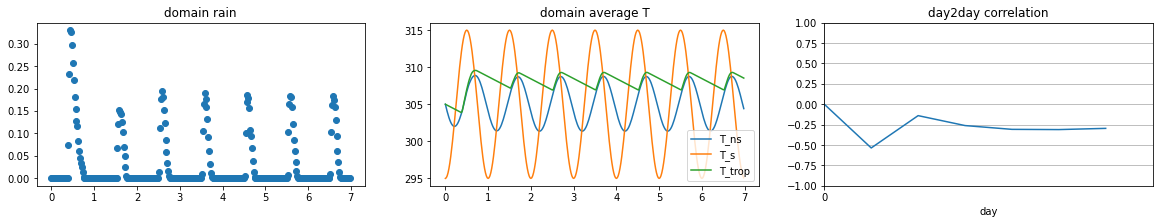

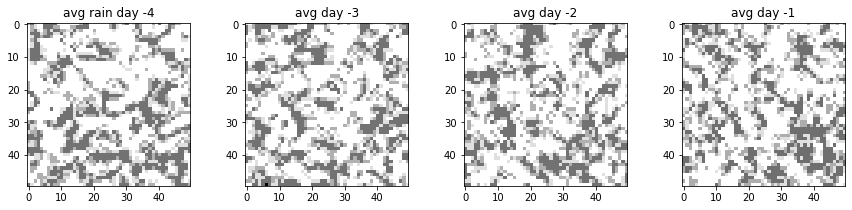

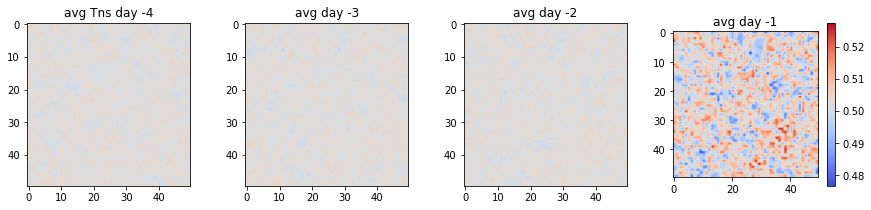

avg activity 0.027597619047619048


In [101]:
%matplotlib inline
fig = plt.figure(figsize=(20,3))
ax1 = plt.subplot(131)

ax1.set_title('domain rain')
ax1.scatter(np.arange(0,np.size(np.mean(x, axis=(1,2)))), np.mean(x, axis=(1,2)))
xaxis=np.arange(0,len(x)+1,48)
ax1.set_xticks(xaxis)
ax1.set_xticklabels([int(i/48) for i in xaxis])
               
ax2 = plt.subplot(132)
ax2.set_title('domain average T')
ax2.plot(np.arange(0,np.size(np.mean(Tns, axis=(1,2)))), 295+20*np.mean(Tns, axis=(1,2)), label='T_ns')
ax2.plot(np.arange(0,np.size(np.mean(Tns, axis=(1,2)))), 295+20*Ts(np.arange(0,np.size(np.mean(Tns, axis=(1,2)))),48,True), label='T_s')
ax2.plot(295+20*trop_temp_saved, label='T_trop')
ax2.legend()
ax2.set_xticks(xaxis)
ax2.set_xticklabels([int(i/48) for i in xaxis])


ax3 = plt.subplot(133)
ax3.set_title('day2day correlation')
ax3.plot(np.arange(0,ndays),calc_corr(x, ndays, N_steps_day=48))
ax3.set_ylim(-1,1)
ax3.set_xlim(0,ndays)
ax3.set_xlabel('day')
ax3.set_xticks(np.arange(0,ndays,14))
ax3.grid()

plt.show()


fig = plt.figure(figsize=(15,3))
day_minus4=np.mean(x[-48*4:-48*3,:,:], axis=(0))
day_minus3=np.mean(x[-48*3:-48*2,:,:], axis=(0))
day_minus2=np.mean(x[-48*2:-48,:,:], axis=(0))
day_last=np.mean(x[-48:-1,:,:], axis=(0))
ax1 = plt.subplot(141)
ax1.imshow(day_minus4, cmap='Greys',vmin=0, vmax=0.1)
ax1.set_title('avg rain day -4')
ax2 = plt.subplot(142)
ax2.imshow(day_minus3, cmap='Greys',vmin=0, vmax=0.1)
ax2.set_title('avg day -3')
ax3 = plt.subplot(143)
ax3.imshow(day_minus2, cmap='Greys',vmin=0, vmax=0.1)
ax3.set_title('avg day -2')
ax4 = plt.subplot(144)
ax4.imshow(day_last, cmap='Greys',vmin=0, vmax=0.1)
ax4.set_title('avg day -1')

fig = plt.figure(figsize=(15,3))
day_minus4=np.mean(Tns[-48*4:-48*3,:,:], axis=(0))
day_minus3=np.mean(Tns[-48*3:-48*2,:,:], axis=(0))
day_minus2=np.mean(Tns[-48*2:-48,:,:], axis=(0))
day_last=np.mean(Tns[-48:-1,:,:], axis=(0))
ax1 = plt.subplot(141)
ax1.imshow(day_minus4, cmap='coolwarm',vmin=0.3, vmax=0.7)
ax1.set_title('avg Tns day -4')
ax2 = plt.subplot(142)
ax2.imshow(day_minus3, cmap='coolwarm',vmin=0.3, vmax=0.7)
ax2.set_title('avg day -3')
ax3 = plt.subplot(143)
ax3.imshow(day_minus2, cmap='coolwarm',vmin=0.3, vmax=0.7)
ax3.set_title('avg day -2')
ax4 = plt.subplot(144)
im4 = ax4.imshow(day_last, cmap='coolwarm')
ax4.set_title('avg day -1')
fig.colorbar(im4, ax=ax4, orientation='vertical')

plt.show()

print('avg activity', np.mean(np.mean(x, axis=(1,2))))


# Run OCEAN and plot


In [21]:
%matplotlib inline
ndays_ocean=28
x_ocean, Tns_ocean, counter_ocean, trop_temp_saved_ocean = modellino(
    N_steps_day=48, tot_steps=48*ndays_ocean, DIU=False, 
    persistence='yes', branching=False, Tns_branch=None) 
# set branching=True and Tns_branch=Tns[-1] to branch from last step of DIU




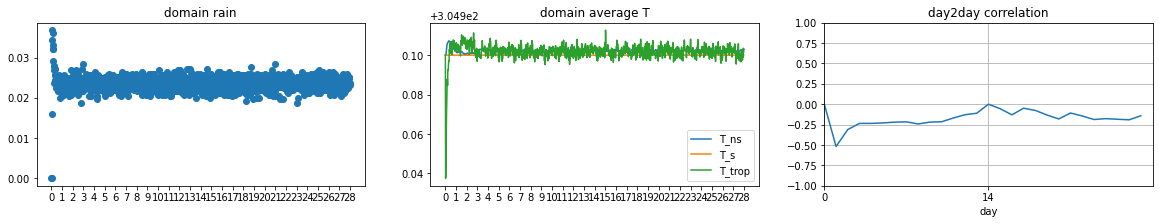

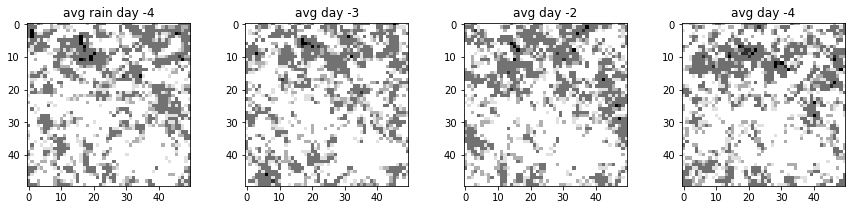

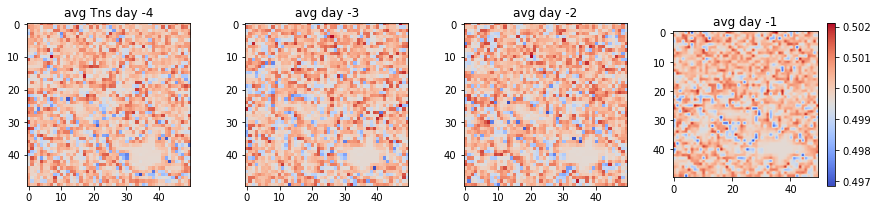

avg activity 0.023473511904761907


In [22]:
%matplotlib inline

fig = plt.figure(figsize=(20,3))
ax1 = plt.subplot(131)

ax1.set_title('domain rain')
ax1.scatter(np.arange(0,np.size(np.mean(x_ocean, axis=(1,2)))), np.mean(x_ocean, axis=(1,2)))
xaxis=np.arange(0,len(x_ocean)+1,48)
ax1.set_xticks(xaxis)
ax1.set_xticklabels([int(i/48) for i in xaxis])

ax2 = plt.subplot(132)
ax2.set_title('domain average T')
ax2.plot(np.arange(0,np.size(np.mean(Tns_ocean, axis=(1,2)))), 295+20*np.mean(Tns_ocean, axis=(1,2)), label='T_ns')
ax2.plot(np.arange(0,np.size(np.mean(Tns_ocean, axis=(1,2)))), 295+20*Ts(0,48, False)*np.ones(np.size(np.mean(Tns_ocean, axis=(1,2)))), label='T_s')
ax2.plot(295+20*trop_temp_saved_ocean, label='T_trop')
ax2.legend()
ax2.set_xticks(xaxis)
ax2.set_xticklabels([int(i/48) for i in xaxis])


ax3 = plt.subplot(133)
ax3.set_title('day2day correlation')
ax3.plot(np.arange(0,ndays_ocean),calc_corr(x_ocean, ndays_ocean, N_steps_day=48))
ax3.set_ylim(-1,1)
ax3.set_xlim(0,ndays_ocean)
ax3.set_xlabel('day')
ax3.set_xticks(np.arange(0,ndays_ocean,14))
ax3.grid()

plt.show()

day_minus4=np.mean(x_ocean[-48*4:-48*3,:,:], axis=(0))
day_minus3=np.mean(x_ocean[-48*3:-48*2,:,:], axis=(0))
day_minus2=np.mean(x_ocean[-48*2:-48,:,:], axis=(0))
day_last=np.mean(x_ocean[-48:-1,:,:], axis=(0))

fig = plt.figure(figsize=(15,3))

ax1 = plt.subplot(141)
ax1.set_title('avg rain day -4')
ax1.imshow(day_minus4, cmap='Greys', vmin=0, vmax=0.1)
ax2 = plt.subplot(142)
ax2.set_title('avg day -3')
ax2.imshow(day_minus3, cmap='Greys',vmin=0, vmax=0.1)
ax3 = plt.subplot(143)
ax3.set_title('avg day -2')
ax3.imshow(day_minus2, cmap='Greys',vmin=0, vmax=0.1)
ax4 = plt.subplot(144)
ax4.set_title('avg day -4')
ax4.imshow(day_last, cmap='Greys',vmin=0, vmax=0.1)
plt.show()

fig = plt.figure(figsize=(15,3))
day_minus4=np.mean(Tns_ocean[-48*4:-48*3,:,:], axis=(0))
day_minus3=np.mean(Tns_ocean[-48*3:-48*2,:,:], axis=(0))
day_minus2=np.mean(Tns_ocean[-48*2:-48,:,:], axis=(0))
day_last=np.mean(Tns_ocean[-48:-1,:,:], axis=(0))
ax1 = plt.subplot(141)
ax1.imshow(day_minus4, cmap='coolwarm')
ax1.set_title('avg Tns day -4')
ax2 = plt.subplot(142)
ax2.imshow(day_minus3, cmap='coolwarm')
ax2.set_title('avg day -3')
ax3 = plt.subplot(143)
ax3.imshow(day_minus2, cmap='coolwarm')
ax3.set_title('avg day -2')
ax4 = plt.subplot(144)
im4 = ax4.imshow(day_last, cmap='coolwarm')
ax4.set_title('avg day -1')
fig.colorbar(im4, ax=ax4, orientation='vertical')
plt.show()

print('avg activity', np.mean(np.mean(x_ocean, axis=(1,2))))

# Run ensemble of DIU + OCEAN + OCEAN branches, and plot

In [23]:
# NOTE: takes a while to run
ensemble_runs = 3 
ndays= 27 + 28
ndays_ocean= 27 + 28
ndays_oceanBRANCH= 28
daybranch= 27

corr_DIU_ALL=np.zeros((ensemble_runs,ndays))
corr_OCEAN_ALL=np.zeros((ensemble_runs,ndays_ocean))
corr_OCEANBRANCH_ALL=np.zeros((ensemble_runs,ndays_oceanBRANCH))

for run in range(0,ensemble_runs):
    
    
    x, Tns, counter,trop_temp_saved = modellino(
        N_steps_day=48, tot_steps=48*ndays, DIU=True, 
        persistence='yes', branching=False, Tns_branch=False)
    
    corr_DIU_ALL[run] = calc_corr(x, ndays, N_steps_day=48)
    
    
    x_oceanBRANCH, Tns_oceanBRANCH, counter_oceanBRANCH, trop_temp_saved_oceanBRANCH = modellino(
        N_steps_day=48, tot_steps=48*ndays_oceanBRANCH, DIU=False, 
        persistence='yes', branching=True, Tns_branch=Tns[daybranch*48])

    
    corr_OCEANBRANCH_ALL[run] = calc_corr(x_oceanBRANCH, ndays_oceanBRANCH, N_steps_day=48)

    x_ocean, Tns_ocean, counter_ocean, trop_temp_saved_ocean = modellino(
        N_steps_day=48, tot_steps=48*ndays_ocean, DIU=False, 
        persistence='yes', branching=False, Tns_branch=False)
    
    corr_OCEAN_ALL[run] = calc_corr(x_ocean, ndays_ocean, N_steps_day=48)

    
    
print('finished')

/Users/ikruse/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/ikruse/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


finished


In [24]:
def plot_branches_all_spread(diu, diu_std, ocean, ocean_std, branch2, branch2_std, name, spread='no',log='no', daybranch=7):
    var = diu
    std = diu_std
    var_ocean = ocean
    std_ocean = ocean_std
    daybranch= daybranch
    var_ocA2 = branch2
    std_ocA2 = branch2_std
    ylabel = str(name)
    fig, ax= plt.subplots(figsize=(4,4), dpi=200)
    var_ocA2[0]=var[daybranch]
    p1, = plt.plot(var,color='forestgreen', label='DIU',linewidth=2, alpha=1)
    p0, = plt.plot(var_ocean, color='navy', linewidth=1, alpha=0.3, label='OCEAN')
    p5, = plt.plot(np.arange(daybranch,daybranch+len(var_ocA2)),var_ocA2,color='dodgerblue', label='OCEAN branch',linewidth=0.5)
    
    if spread=='yes':
        p1 = plt.fill_between(np.arange(len(var)), (var-std), (var+std), color='forestgreen', alpha=.1)
        p0 = plt.fill_between(np.arange(len(var_ocean)), (var_ocean-std_ocean), (var_ocean+std_ocean), color='navy', alpha=.1)
        p5 = plt.fill_between(np.arange(daybranch,daybranch+len(var_ocA2)), (var_ocA2-std_ocA2), (var_ocA2+std_ocA2), color='dodgerblue', alpha=.1)
    
    
    plt.plot(np.zeros(daybranch+len(var_ocA2)), color='black')
    plt.title('')
    plt.xlabel('time [day of sim]')
    plt.ylabel(ylabel)
    if log=='yes':
        plt.yticks(np.linspace(-3,0,2))
        plt.ylim((10e-5,10e-1))
        plt.yscale('log') 
    l1 = plt.legend([p1,p0], ['DIU ensemble','OCEAN ensemble'], loc=2)
    l2 = plt.legend([p5], ['DIU2OCEAN branch ensemble'], loc=4)
    plt.gca().add_artist(l1) 
    plt.show()
    return

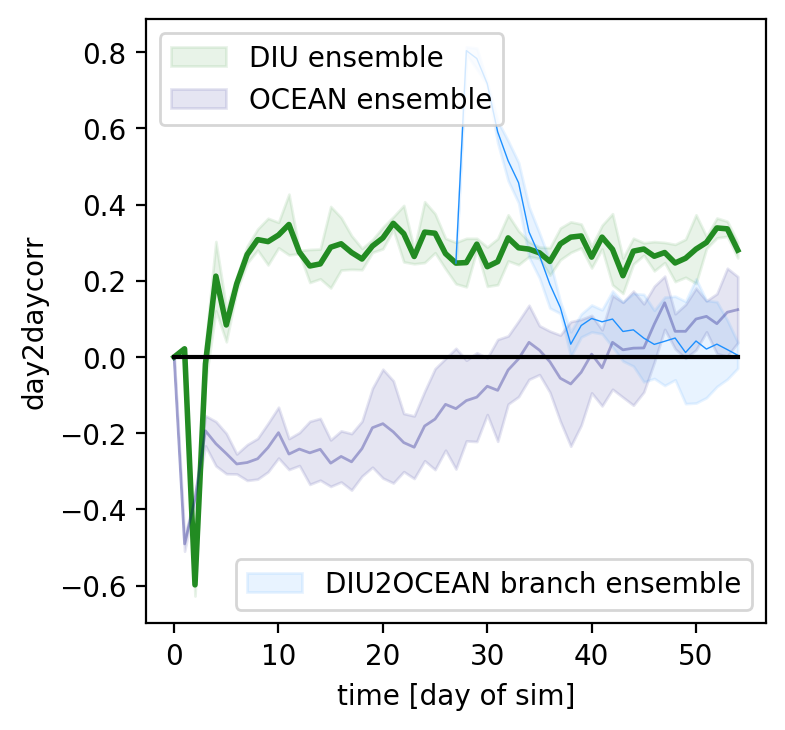

In [25]:
diu = np.nanmean(corr_DIU_ALL, axis=0)
diu_std = np.nanstd(corr_DIU_ALL, axis=0)
ocean = np.nanmean(corr_OCEAN_ALL, axis=0)
ocean_std = np.nanstd(corr_OCEAN_ALL, axis=0)
branch2 = np.nanmean(corr_OCEANBRANCH_ALL,axis=0)
branch2_std = np.nanstd(corr_OCEANBRANCH_ALL,axis=0)

plot_branches_all_spread(diu, diu_std, ocean, ocean_std, branch2, branch2_std, 
                         'day2daycorr', spread='yes', daybranch=27)



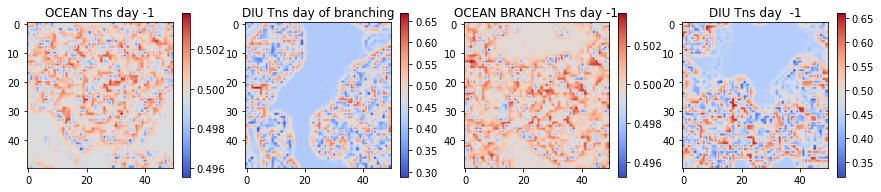

In [26]:
fig = plt.figure(figsize=(15,3))
vmin=0.5
vmax=0.55
daybranch=27
ax1 = plt.subplot(141)
ax1.set_title('OCEAN Tns day -1')
ax2 = plt.subplot(142)
ax2.set_title('DIU Tns day of branching')
ax3 = plt.subplot(143)
ax3.set_title('OCEAN BRANCH Tns day -1')
ax4 = plt.subplot(144)
ax4.set_title('DIU Tns day  -1')
im1 = ax1.imshow(Tns_ocean[-1], cmap='coolwarm')
im2 = ax2.imshow(Tns[daybranch*48], cmap='coolwarm')
im3 = ax3.imshow(Tns_oceanBRANCH[-1],cmap='coolwarm')
im4 = ax4.imshow(Tns[-1],cmap='coolwarm')
fig.colorbar(im1, ax=ax1, orientation='vertical')
fig.colorbar(im2, ax=ax2, orientation='vertical')
fig.colorbar(im3, ax=ax3, orientation='vertical')
fig.colorbar(im4, ax=ax4, orientation='vertical')
plt.show()